# 파이토치로 구현하는 신경망

## 신경망 모델 구현하기

In [1]:
import torch
import torch.nn.functional as F
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plot

In [2]:
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

In [3]:
print(y_train)

[1 1 1 1 2 0 0 3 2 3 2 3 2 1 3 3 2 0 0 2 3 0 2 1 0 1 1 2 0 1 2 0 2 3 0 0 0
 0 1 1 1 0 1 0 2 2 3 1 3 0 0 3 1 2 2 3 0 2 3 2 2 2 3 1 3 3 1 1 3 2 3 2 1 0
 1 0 3 3 3 0]


In [4]:
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

데이터가 제대로 만들어 졌는지, 그리고 제대로 레이블링이 되었는지 확인하기 위해 matplotlib 을 이용해 데이터를 시각화 해 보겠습니다.

레이블이 0 인 학습 데이터는 점으로, 1인 데이터는 십자가로 표시했습니다.

<img src="./images/data_distribution.png" width="200">

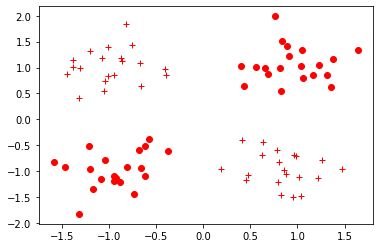

In [5]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plot.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plot.figure()
vis_data(x_train, y_train, c='r')
plot.show()

마지막으로 신경망을 구현 하기 전, 위에서 정의한 데이터들을 넘파이 리스트가 아닌 파이토치 텐서로 바꿔줍니다.

In [6]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [7]:
class NeuralNet(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor):
            linear1 = self.linear_1(input_tensor)
            relu = self.relu(linear1)
            linear2 = self.linear_2(relu)
            output = self.sigmoid(linear2)
            return output

In [8]:
model = NeuralNet(2, 5)
learning_rate = 0.03
criterion = torch.nn.BCELoss()
epochs = 1000
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [9]:
model.eval()
test_loss_before =  criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is ', test_loss_before.item())

Before Training, test loss is  0.7183062434196472


오차값이 0.73 이 나왔습니다. 이정도의 오차를 가진 모델은 사실상 분류하는 능력이 없다고 봐도 무방합니다.
자, 이제 드디어 인공신경망을 학습시켜 퍼포먼스를 향상시켜 보겠습니다.

In [10]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at ', epoch, 'is ', train_loss.item())
    train_loss.backward()
    optimizer.step()

Train loss at  0 is  0.7176607847213745
Train loss at  100 is  0.6683902144432068
Train loss at  200 is  0.6202421188354492
Train loss at  300 is  0.5565215349197388
Train loss at  400 is  0.49706268310546875
Train loss at  500 is  0.45723819732666016
Train loss at  600 is  0.43104809522628784
Train loss at  700 is  0.4129379689693451
Train loss at  800 is  0.4012666642665863
Train loss at  900 is  0.392312228679657


In [11]:
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test) 
print('After Training, test loss is ', test_loss.item())

After Training, test loss is  0.36470338702201843


학습을 하기 전과 비교했을때 현저하게 줄어든 오차값을 확인 하실 수 있습니다.
지금까지 인공신경망을 구현하고 학습시켜 보았습니다.
이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [12]:
torch.save(model.state_dict(), './model.pt')

`save()` 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 model.pt 라는 파일이 생성됩니다. 아래 코드처럼 새로운 신경망 객체에 model.pt 속의 가중치값을 입력시키는 것 또한 가능합니다.

In [13]:
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print(new_model(torch.FloatTensor([-1,1])).item() )

0.9581117033958435


벡터 [-1,1]을 학습하고 저장된 모델에 입력시켰을 때 레이블이 1일 확률은 90% 이상이 나옵니다.
우리의 첫번째 신경망 모델은 이제 꽤 믿을만한 분류 작업이 가능하게 된 것입니다.

```python
벡터 [-1,1]이 레이블 1 을 가질 확률은  0.9745796918869019
```